In [1]:
import numpy as np 
import pandas as pd
#import calendar
import math

# plots
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline

In [2]:
filenames = ['properties/properati-AR-2016-03-01-properties-sell-six_months.csv',
            'properties/properati-AR-2016-04-01-properties-sell.csv',
            'properties/properati-AR-2016-05-01-properties-sell.csv',
            'properties/properati-AR-2016-06-01-properties-sell.csv',
            'properties/properati-AR-2016-07-01-properties-sell.csv',
            'properties/properati-AR-2016-08-01-properties-sell.csv',
            'properties/properati-AR-2016-09-01-properties-sell.csv',
            'properties/properati-AR-2016-10-01-properties-sell.csv',
            'properties/properati-AR-2016-11-01-properties-sell.csv',
            'properties/properati-AR-2016-12-01-properties-sell.csv', 
            'properties/properati-AR-2017-01-01-properties-sell.csv',
            'properties/properati-AR-2017-02-01-properties-sell.csv',
            'properties/properati-AR-2017-08-01-properties-sell-six_months.csv']

dataframes = []
for filename in filenames:
    dataframes.append(pd.read_csv(filename))

# SAQUE ESTO PARA HACER LA REGRESION A PARTIR DEL 2DO SEMESTRE DEL 2016
#dataframes.append(pd.read_csv('properties/properati-AR-2015-07-01-properties-sell.csv', skiprows=[81550]))
#dataframes.append(pd.read_csv('properties/properati-AR-2015-08-01-properties-sell.csv', skiprows=[75032]))
#dataframes.append(pd.read_csv('properties/properati-AR-2015-09-01-properties-sell.csv', skiprows=[54374]))
#dataframes.append(pd.read_csv('properties/properati-AR-2015-12-01-properties-sell.csv', skiprows=[101832]))
#Uno los dataframe
data = pd.DataFrame()
for dataframe in dataframes:
    data = pd.concat([data, dataframe]).drop_duplicates().reset_index(drop=True)


In [28]:
data = data.loc[data.place_with_parent_names.str.contains('Capital Federal') | \
                data.place_with_parent_names.str.contains('Buenos Aires'),:]
data.info()
# 1.283.741 entries antes, ahora 296476, se redujeron 1/4 los datos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115935 entries, 9 to 296476
Data columns (total 27 columns):
id                            115935 non-null object
created_on                    115935 non-null object
operation                     115935 non-null object
property_type                 115935 non-null object
place_name                    115935 non-null object
place_with_parent_names       115935 non-null object
country_name                  115935 non-null object
state_name                    115935 non-null object
geonames_id                   110181 non-null float64
lat-lon                       98587 non-null object
lat                           98587 non-null float64
lon                           98587 non-null float64
price                         107452 non-null float64
currency                      105164 non-null object
price_aprox_local_currency    107452 non-null float64
price_aprox_usd               107452 non-null float64
surface_total_in_m2           84322 no

In [4]:
test = pd.read_csv('properties/properati_dataset_testing_noprice.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 17 columns):
id                         14166 non-null int64
created_on                 14166 non-null object
property_type              14166 non-null object
operation                  14166 non-null object
place_name                 14166 non-null object
place_with_parent_names    14166 non-null object
country_name               14166 non-null object
state_name                 14166 non-null object
lat-lon                    10487 non-null object
lat                        10487 non-null float64
lon                        10487 non-null float64
surface_total_in_m2        11853 non-null float64
surface_covered_in_m2      13005 non-null float64
floor                      1368 non-null float64
rooms                      7500 non-null float64
expenses                   2543 non-null object
description                14166 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 1

<br><B><FONT FACE="Arial" SIZE="5">Prediccion usando regresion lineal, en base a las propiedades: 'price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms'</FONT></B><br/>

In [29]:
data_float = data.loc[:, ['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2',\
                          'floor', 'rooms', 'lat', 'lon']].dropna(axis= 0, how='any')
#test_float = test.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2']].dropna(axis= 0, how='any')

#filtro
data_float = \
data_float.loc[((data_float.surface_total_in_m2 >= 15.0) & (data_float.surface_total_in_m2 <= 1000.0)) & \
               ((data_float.surface_covered_in_m2 >= 15.0) & (data_float.surface_covered_in_m2 <= 500.0)) & \
               ((data_float.floor >= 1.0) & (data_float.floor <= 6.0)) & \
               ((data_float.rooms >= 1.0) & (data_float.rooms <= 8.0)), :]


#test_float = test_float.loc[(test_float.surface_total_in_m2 >= 42.0) & (test_float.surface_total_in_m2 <= 88.0), :]
#test_float = test_float.loc[(test_float.surface_covered_in_m2 >= 39.0) & (test_float.surface_covered_in_m2 <= 80.0), :]
#test_float = test_float.loc[(test_float.floor >= 1.0) & (test_float.floor <= 6.0), :]
#test_float = test_float.loc[(test_float.rooms >= 1.0) & (test_float.rooms <= 3.0), :]


data_float.describe()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,floor,rooms,lat,lon
count,2.786000e+03,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000,2786.000000
mean,1.506283e+05,74.912419,64.806892,2.806533,2.622039,-34.722552,-58.376806
std,1.143988e+05,51.735804,39.943632,1.699796,1.162707,0.614049,0.347740
min,0.000000e+00,17.000000,17.000000,1.000000,1.000000,-38.583214,-65.409012
25%,8.606250e+04,43.000000,39.000000,1.000000,2.000000,-34.615499,-58.457242
50%,1.250000e+05,62.000000,54.000000,2.000000,3.000000,-34.602074,-58.434093
75%,1.750000e+05,88.000000,79.000000,4.000000,3.000000,-34.586155,-58.403016
max,1.600000e+06,674.000000,494.000000,6.000000,8.000000,-24.783399,-56.677077


In [120]:
# esto no sirvio 
#def propertyTypeToNumber(x):
#    if (x == 'house'): return 1
#    if (x == 'PH'): return 2
#    if (x == 'apartment'): return 3

#data_float['property_type_n'] = data_float['property_type'].apply(propertyTypeToNumber)
#data_float['property_type_n'].head(10)

In [6]:
data_float.shape

(5069, 7)

In [15]:
import pandas as pd
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(data_float)
data_float_norm = pd.DataFrame(np_scaled)
data_float_norm.columns=['price_aprox_usd', 'surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms',\
                      'lat', 'lon']
data_float_norm.describe()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,floor,rooms,lat,lon
count,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000,5567.000000
mean,0.066184,0.063143,0.085172,0.352829,0.194052,0.404168,0.815288
std,0.057307,0.058232,0.070865,0.332083,0.148570,0.065743,0.092656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.037368,0.030651,0.044025,0.000000,0.142857,0.398042,0.827277
50%,0.051053,0.047254,0.062893,0.200000,0.142857,0.399636,0.833343
75%,0.078947,0.075351,0.104822,0.600000,0.285714,0.401205,0.836504
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [123]:
# para evitar la normalización meter esos hashtags acá
#data_float = data_float_norm
#data_float.describe()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,floor,rooms,lat,lon
count,9285.000000,9285.000000,9285.000000,9285.000000,9285.000000,9285.000000,9285.000000
mean,0.005757,0.062735,0.084995,0.358923,0.188722,0.103939,0.430522
std,0.020451,0.058222,0.073495,0.332819,0.148159,0.017007,0.015504
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003089,0.030651,0.044025,0.000000,0.142857,0.102837,0.431566
50%,0.004049,0.045977,0.062893,0.200000,0.142857,0.103240,0.432558
75%,0.006220,0.074074,0.102725,0.600000,0.285714,0.103542,0.433091
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
#Creo X e Y
feature_cols = ['surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms']
X = data_float[feature_cols]
y = data_float.price_aprox_usd

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X, y)

# Printeo los coeficientes
print (lm.intercept_)
print (lm.coef_)


9762.44669791
[ -113.64609508  2127.88176081  3311.02714971   833.50393266]


In [31]:
# Uno los coeficientes con su respectiva columna
zip(feature_cols, lm.coef_)

In [32]:
test.shape

(14166, 21)

In [10]:
def propertyTypeToNumberTest(x):
    if (x == 'casa'): return 1
    if (x == 'ph'): return 2
    if (x == 'departmento'): return 3
    else: return 0


test_float = test
test_float.fillna(0, inplace=True)
#test_float['property_type_n'] = test_float['property_type'].apply(propertyTypeToNumberTest)
test_float.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 17 columns):
id                         14166 non-null int64
created_on                 14166 non-null object
property_type              14166 non-null object
operation                  14166 non-null object
place_name                 14166 non-null object
place_with_parent_names    14166 non-null object
country_name               14166 non-null object
state_name                 14166 non-null object
lat-lon                    14166 non-null object
lat                        14166 non-null float64
lon                        14166 non-null float64
surface_total_in_m2        14166 non-null float64
surface_covered_in_m2      14166 non-null float64
floor                      14166 non-null float64
rooms                      14166 non-null float64
expenses                   14166 non-null object
description                14166 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage

In [33]:
test_float['price_aprox_usd_LR'] = lm.predict(test_float.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2',\
                                'floor', 'rooms']])
test_float.head()
#PREGUNTAS
#HAY QUE FILTRAR EL .CSV QUE TENEMOS QUE PREDECIR? HAY DATOS TRUCHOS. ésta es una pregunta realmente importante
#USANDO REGRESION, HAGO LA PREDDCION DE LAS PROPIEDADES QUE SOLAMENTE TIENEN LAS 4 COLUMNAS CON DATOS POR LAS QUE HAGO
#LA PREDICCION?

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,...,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description,price_aprox_usd_LR,price_aprox_usd_KNN5,price_aprox_usd_KNN_49,price_aprox_usd_KNN_46_lat_lon
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,...,0.0,0.0,0.0,0.0,0,Edificio BA Houses situado frente al Dique 3 d...,9762.446698,58980.000,53480.608571,53567.387391
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,0,0.000000,...,0.0,0.0,0.0,0.0,0,El departamento cuenta con un living-comedor a...,9762.446698,58980.000,53480.608571,53567.387391
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,...,53.0,48.0,0.0,0.0,1500,IMPECABLE TORRE COY III – DEPA...,105877.528178,107600.000,104154.815102,105599.694348
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,39.0,39.0,0.0,0.0,0,AMBIENTE DIVISIBLE CON PISOS D...,88317.637661,38457.078,66234.776327,44619.704783
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,51.0,51.0,0.0,0.0,0,LIVING COMEDOR CON PISOS DE PO...,112488.465650,240000.000,103916.237143,71741.728478


<br><B><FONT FACE="Arial" SIZE="5">KNN</FONT></B><br/>

In [34]:
#Un ejemplo de knn
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5, metric='euclidean')
knn.fit(X, y)

test_float['price_aprox_usd_KNN5'] = knn.predict(test_float.loc[:, ['surface_total_in_m2', \
                            'surface_covered_in_m2', 'floor', 'rooms']])
test_float.head()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,...,surface_total_in_m2,surface_covered_in_m2,floor,rooms,expenses,description,price_aprox_usd_LR,price_aprox_usd_KNN5,price_aprox_usd_KNN_49,price_aprox_usd_KNN_46_lat_lon
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,...,0.0,0.0,0.0,0.0,0,Edificio BA Houses situado frente al Dique 3 d...,9762.446698,58960.000,53480.608571,53567.387391
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,0,0.000000,...,0.0,0.0,0.0,0.0,0,El departamento cuenta con un living-comedor a...,9762.446698,58960.000,53480.608571,53567.387391
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,...,53.0,48.0,0.0,0.0,1500,IMPECABLE TORRE COY III – DEPA...,105877.528178,116000.000,104154.815102,105599.694348
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,39.0,39.0,0.0,0.0,0,AMBIENTE DIVISIBLE CON PISOS D...,88317.637661,70100.000,66234.776327,44619.704783
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,51.0,51.0,0.0,0.0,0,LIVING COMEDOR CON PISOS DE PO...,112488.465650,75263.514,103916.237143,71741.728478


In [35]:
#Knn con cross-validation
from sklearn.model_selection import cross_val_score
# creating odd list of K for KNN
neighbors = list(range(1,100))


# subsetting just the odd ones
#neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 25


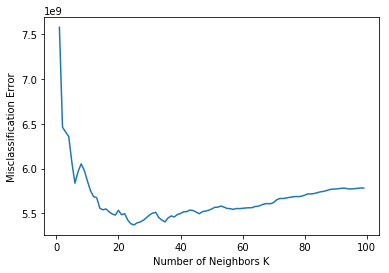

In [36]:
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [37]:
#Un ejemplo de knn
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=25, metric='euclidean')
knn.fit(X, y)

test_float['price_aprox_usd_KNN_25'] = knn.predict(test_float.loc[:, ['surface_total_in_m2', 'surface_covered_in_m2',\
                                        'floor', 'rooms']])
test_float.head()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,...,surface_covered_in_m2,floor,rooms,expenses,description,price_aprox_usd_LR,price_aprox_usd_KNN5,price_aprox_usd_KNN_49,price_aprox_usd_KNN_46_lat_lon,price_aprox_usd_KNN_25
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,...,0.0,0.0,0.0,0,Edificio BA Houses situado frente al Dique 3 d...,9762.446698,58960.000,53480.608571,53567.387391,59760.0000
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,0,0.000000,...,0.0,0.0,0.0,0,El departamento cuenta con un living-comedor a...,9762.446698,58960.000,53480.608571,53567.387391,59760.0000
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,...,48.0,0.0,0.0,1500,IMPECABLE TORRE COY III – DEPA...,105877.528178,116000.000,104154.815102,105599.694348,114079.4376
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,39.0,0.0,0.0,0,AMBIENTE DIVISIBLE CON PISOS D...,88317.637661,70100.000,66234.776327,44619.704783,76600.0000
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,51.0,0.0,0.0,0,LIVING COMEDOR CON PISOS DE PO...,112488.465650,75263.514,103916.237143,71741.728478,83114.0788


In [38]:
test_float_reduced = test_float.loc[:,['id', 'price_aprox_usd_KNN_25']]
test_float_reduced.head(10)

,id,price_aprox_usd_KNN_25
0,3632,59760.0000
1,3633,59760.0000
2,2263404,114079.4376
3,2263405,76600.0000
4,2263406,83114.0788
5,2263407,76600.0000
6,2263408,76600.0000
7,2263409,76600.0000
8,2263410,122760.0000
9,2263411,94693.6900


In [22]:
test_float_reduced.columns=['id', 'price_usd']
test_float_reduced.head()

,id,price_usd
0,3632,53480.608571
1,3633,53480.608571
2,2263404,104154.815102
3,2263405,66234.776327
4,2263406,103916.237143


In [137]:
test_float_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 2 columns):
id           14166 non-null int64
price_usd    14166 non-null float64
dtypes: float64(1), int64(1)
memory usage: 221.4 KB


In [103]:
#test_float_reduced.to_csv('SubmitNew1.csv', index=False)

## KNN con 'lat' y 'lon'

In [39]:
#Knn con cross-validation

feature_cols2 = ['surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms', 'lat', 'lon']
X2 = data_float[feature_cols2]


from sklearn.model_selection import cross_val_score
# creating odd list of K for KNN
neighbors = list(range(1,200))


# subsetting just the odd ones
#neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores2 = []

# perform 10-fold cross validation
for k in neighbors:
    knn2 = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn2, X2, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores2.append(scores.mean())


The optimal number of neighbors is 25


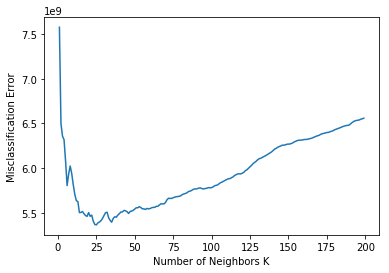

In [40]:

MSE2 = [1 - x for x in cv_scores2]

# determining best k
optimal_k2 = neighbors[MSE2.index(min(MSE2))]
print ("The optimal number of neighbors is %d" % optimal_k2)

# plot misclassification error vs k
plt.plot(neighbors, MSE2)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [41]:
#Un ejemplo de knn
from sklearn.neighbors import KNeighborsRegressor
knn2 = KNeighborsRegressor(n_neighbors=25, metric='euclidean')
knn2.fit(X2, y)

test_float['price_aprox_usd_KNN_25_lat_lon'] = knn2.predict(test_float.loc[:, ['surface_total_in_m2', \
                                'surface_covered_in_m2', 'floor', 'rooms', 'lat', 'lon']])
test_float.head()

,id,created_on,property_type,operation,place_name,place_with_parent_names,country_name,state_name,lat-lon,lat,...,floor,rooms,expenses,description,price_aprox_usd_LR,price_aprox_usd_KNN5,price_aprox_usd_KNN_49,price_aprox_usd_KNN_46_lat_lon,price_aprox_usd_KNN_25,price_aprox_usd_KNN_25_lat_lon
0,3632,2017-08-24,departamento,venta,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Argentina,Capital Federal,"-34.6109877599,-58.3634635778",-34.610988,...,0.0,0.0,0,Edificio BA Houses situado frente al Dique 3 d...,9762.446698,58960.000,53480.608571,53567.387391,59760.0000,59760.0000
1,3633,2017-08-25,departamento,venta,Buenos Aires Interior,|Argentina|Buenos Aires Interior|,Argentina,Buenos Aires Interior,0,0.000000,...,0.0,0.0,0,El departamento cuenta con un living-comedor a...,9762.446698,58960.000,53480.608571,53567.387391,59760.0000,59760.0000
2,2263404,2017-08-01,departamento,venta,Palermo Soho,|Argentina|Capital Federal|Palermo|Palermo Soho|,Argentina,Capital Federal,"-34.5893633232,-58.4128798588",-34.589363,...,0.0,0.0,1500,IMPECABLE TORRE COY III – DEPA...,105877.528178,116000.000,104154.815102,105599.694348,114079.4376,114079.4376
3,2263405,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,0.0,0.0,0,AMBIENTE DIVISIBLE CON PISOS D...,88317.637661,70100.000,66234.776327,44619.704783,76600.0000,63640.0000
4,2263406,2017-08-01,departamento,venta,Chacarita,|Argentina|Capital Federal|Chacarita|,Argentina,Capital Federal,0,0.000000,...,0.0,0.0,0,LIVING COMEDOR CON PISOS DE PO...,112488.465650,75263.514,103916.237143,71741.728478,83114.0788,85618.7432


In [42]:
test_float_reduced = test_float.loc[:,['id', 'price_aprox_usd_KNN_25_lat_lon']]
test_float_reduced.head(10)

,id,price_aprox_usd_KNN_25_lat_lon
0,3632,59760.0000
1,3633,59760.0000
2,2263404,114079.4376
3,2263405,63640.0000
4,2263406,85618.7432
5,2263407,63640.0000
6,2263408,63640.0000
7,2263409,63640.0000
8,2263410,126480.0000
9,2263411,93480.0000


In [43]:
test_float_reduced.columns=['id', 'price_usd']
test_float_reduced.head()

,id,price_usd
0,3632,59760.0000
1,3633,59760.0000
2,2263404,114079.4376
3,2263405,63640.0000
4,2263406,85618.7432


In [146]:
test_float_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14166 entries, 0 to 14165
Data columns (total 2 columns):
id           14166 non-null int64
price_usd    14166 non-null float64
dtypes: float64(1), int64(1)
memory usage: 221.4 KB


In [44]:
test_float_reduced.to_csv('SubmitNew4.csv', index=False)